In [40]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
import pandas as pd
import seaborn as sns
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
from scipy.signal import savgol_filter

In [81]:
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, 'recording_programs',"test_data", "sensor_dec_01")
_folder_name = "imu_16_random_01"
_pth = os.path.join(_base_pth, _folder_name)
_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\sensor_dec_01\\imu_16_random_01'

In [82]:
_sensor_df = pd.read_csv(os.path.join(_pth, "imu01.csv"))
_sensor_df["del_t"] = _sensor_df["rust_time"].diff()

In [83]:
_sensor_df["gy"] = savgol_filter(_sensor_df["gy"], 51, 1)
_sensor_df["gx"] = savgol_filter(_sensor_df["gx"], 51, 1)
_sensor_df["gz"] = savgol_filter(_sensor_df["gz"], 51, 1)

In [84]:
val_x = _sensor_df["gx"][:500].mean()
val_y = _sensor_df["gy"][:500].mean()
val_z = _sensor_df["gz"][:500].mean()

In [85]:
# calculating angle from gx, gy, gz

for i in range(len(_sensor_df)):
    if i == 0:
        _sensor_df.loc[i, "angle_gx"] = 0
        _sensor_df.loc[i, "angle_gy"] = 0
        _sensor_df.loc[i, "angle_gz"] = 0
    else:
        _sensor_df.loc[i, "angle_gx"] = _sensor_df.loc[i-1, "angle_gx"] + (_sensor_df.loc[i, "gx"] - val_x) * 0.01 
        _sensor_df.loc[i, "angle_gy"] = _sensor_df.loc[i-1, "angle_gy"] + (_sensor_df.loc[i, "gy"] - val_y) * 0.01
        _sensor_df.loc[i, "angle_gz"] = _sensor_df.loc[i-1, "angle_gz"] + (_sensor_df.loc[i, "gz"] - val_z) * 0.01

_sensor_df["sys_time"] = pd.to_datetime(_sensor_df["sys_time"])

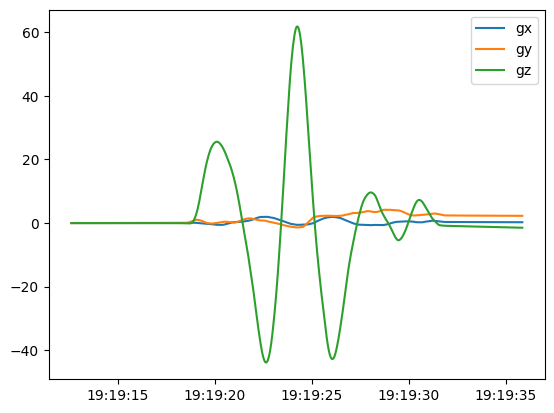

In [86]:
plt.plot(_sensor_df["sys_time"], _sensor_df["angle_gx"], label="gx")
plt.plot(_sensor_df["sys_time"], _sensor_df["angle_gy"], label="gy")
plt.plot(_sensor_df["sys_time"], _sensor_df["angle_gz"], label="gz")
plt.legend()

In [77]:
# read mocap data from csv

_mocap_pth = os.path.join(_base_pth, "imu17", _folder_name + ".csv")
_mocap_df, st_time = read_df_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
_mocap_df

,frame,seconds,org_x,org_y,org_z,xvec_x,xvec_y,xvec_z,zvec_x,zvec_y,zvec_z,time
0,0,0.00,0.335351,0.067984,0.159479,0.380193,0.067667,0.159935,0.335323,0.069198,0.263888,2022-12-02 11:42:37.613
1,1,0.01,0.335347,0.067987,0.159475,0.380189,0.067661,0.159937,0.335318,0.069199,0.263890,2022-12-02 11:42:37.623
2,2,0.02,0.335347,0.067988,0.159474,0.380189,0.067677,0.159943,0.335313,0.069202,0.263887,2022-12-02 11:42:37.633
3,3,0.03,0.335351,0.067993,0.159471,0.380189,0.067669,0.159942,0.335309,0.069197,0.263884,2022-12-02 11:42:37.643
4,4,0.04,0.335350,0.067990,0.159476,0.380184,0.067672,0.159939,0.335318,0.069205,0.263892,2022-12-02 11:42:37.653
...,...,...,...,...,...,...,...,...,...,...,...,...
2270,2270,22.70,0.245388,0.069125,0.155362,0.290161,0.068559,0.151884,0.254465,0.070583,0.259185,2022-12-02 11:43:00.313
2271,2271,22.71,0.245392,0.069143,0.155377,0.290153,0.068579,0.151900,0.254474,0.070574,0.259194,2022-12-02 11:43:00.323
2272,2272,22.72,0.245383,0.069133,0.155356,0.290153,0.068563,0.151878,0.254469,0.070583,0.259204,2022-12-02 11:43:00.333
2273,2273,22.73,0.245386,0.069122,0.155355,0.290151,0.068553,0.151881,0.254471,0.070573,0.259188,2022-12-02 11:43:00.343


In [78]:
# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_rotmat_i = []
for i in range(len(_m_df)):
    _x_vec = _m_df[["xvec_x", "xvec_y", "xvec_z"]].loc[i].values
    _x_vec = np.reshape(_x_vec, (3,1))
    _org = _m_df[["org_x", "org_y", "org_z"]].loc[i].values
    _org = np.reshape(_org, (3,1))
    _z_vec = _m_df[["zvec_x", "zvec_y", "zvec_z"]].loc[i].values
    _z_vec = np.reshape(_z_vec, (3,1))
    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in range(len(_rotmat_i)):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in _del_r:
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

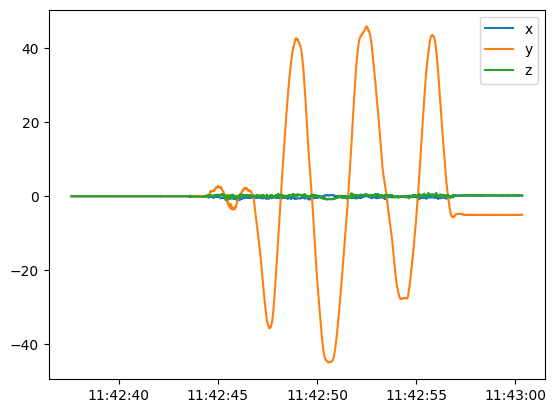

In [79]:
plt.plot(_mocap_df["time"], _theta_x, label="x")
plt.plot(_mocap_df["time"], _theta_y, label="y")
plt.plot(_mocap_df["time"], _theta_z, label="z")
plt.legend()


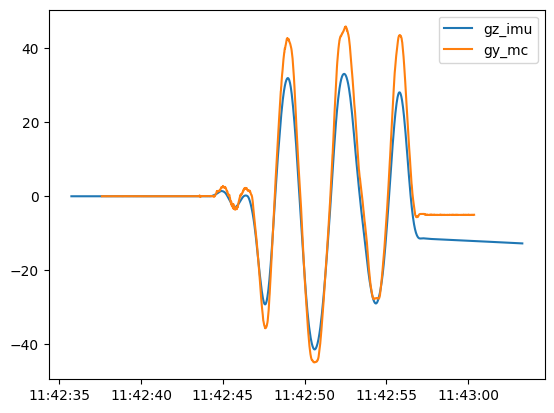

In [80]:
val = _sensor_df["gz"][:500].mean()

plt.plot(_sensor_df["sys_time"], _sensor_df["angle_gz"]*-1 , label="gz_imu")
plt.plot(_mocap_df["time"], _theta_y, label="gy_mc")
plt.legend()

In [72]:
val_x = _sensor_df["gx"][:500].mean()
val_y = _sensor_df["gy"][:500].mean()
val_z = _sensor_df["gz"][:500].mean()
val

0.4830074077938116

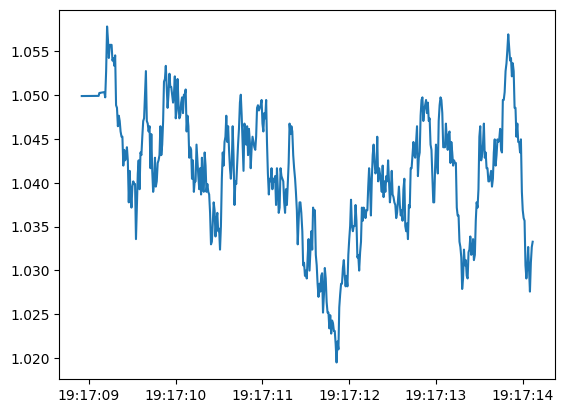

In [54]:
plt.plot(_sensor_df["sys_time"][:500], _sensor_df["gz"][:500], label="gx_imu")

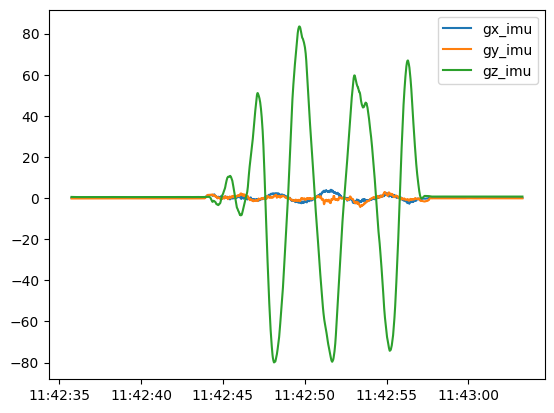

In [73]:
plt.plot(_sensor_df["sys_time"], _sensor_df["gx"], label="gx_imu")
plt.plot(_sensor_df["sys_time"], _sensor_df["gy"], label="gy_imu")
plt.plot(_sensor_df["sys_time"], _sensor_df["gz"], label="gz_imu")
plt.legend()